In [1]:
import xarray as xr
import re
import numpy as np
import sys
# Import the function that calls NN
sys.path.append('../../example/')
from call import ann_flux, ann_flux_xarray
%load_ext autoreload
%autoreload 3

In [3]:
path = '/scratch/jw8736/mlflux/data/Global/'
ds = xr.open_dataset(path + 'sample_processed.nc')
ds

<xarray.Dataset>
Dimensions:                   (time: 119, ocnImp_ny: 480, ocnImp_nx: 540)
Coordinates:
  * time                      (time) object 0001-01-01 01:00:00 ... 0001-01-0...
  * ocnImp_ny                 (ocnImp_ny) int64 0 1 2 3 4 ... 476 477 478 479
  * ocnImp_nx                 (ocnImp_nx) int64 0 1 2 3 4 ... 536 537 538 539
Data variables: (12/29)
    Ta                        (time, ocnImp_ny, ocnImp_nx) float64 ...
    ux                        (time, ocnImp_ny, ocnImp_nx) float64 ...
    uy                        (time, ocnImp_ny, ocnImp_nx) float64 ...
    z                         (time, ocnImp_ny, ocnImp_nx) float64 ...
    p                         (time, ocnImp_ny, ocnImp_nx) float64 ...
    q                         (time, ocnImp_ny, ocnImp_nx) float64 ...
    ...                        ...
    Qs_nn                     (time, ocnImp_ny, ocnImp_nx) float64 ...
    Ql_nn                     (time, ocnImp_ny, ocnImp_nx) float64 ...
    Ql_b                      (time, ocnImp_ny, ocnImp_nx) float64 ...
    Qs_b                      (time, ocnImp_ny, ocnImp_nx) float64 ...
    taux_b                    (time, ocnImp_ny, ocnImp_nx) float64 ...
    tauy_b                    (time, ocnImp_ny, ocnImp_nx) float64 ...

### Compute using ANN

In [7]:
# Rename some fields
ds = ds.rename({'atmImp_Sa_u':'ux', 'atmImp_Sa_v':'uy', 
                'ocnImp_So_t':'To', 'atmImp_Sa_tbot':'Ta',
                'atmImp_Sa_pbot':'p', 'atmImp_Sa_shum':'q',
                'atmImp_Sa_z':'z'})
# Adjust units
ds['To'] = ds['To'] - 273.15
ds['Ta'] = ds['Ta'] - 273.15
ds = ann_flux_xarray(ds)
ds = ds.rename({'taux':'taux_nn', 'tauy':'tauy_nn', 
                'Qs':'Qs_nn', 'Ql':'Ql_nn'})

### Compute with bulk algorithm (COARE)

In [ ]:
try:
    from aerobulk.flux import noskin 
except ImportError:
    pass
'''
Inputs of aerobulk:            
    t_zt: Air temperature (kelvin)
    sst: Ocean temperature (kelvin)
    p: Sea surface pressure in pascal 
    q: Specific humidity (kg/kg)
'''
def apply_bulk(ds):
    U = (ds.ux**2 + ds.uy**2)**0.5
    cos = ds.ux / U
    sin = ds.uy / U
    hl, hs, tau, tau_cross, evap = noskin(sst=ds.To+273.15, t_zt=ds.Ta+273.15, 
                                      hum_zt=ds.q, u_zu=U, v_zu=U*0, 
                                      slp=ds.p, algo='coare3p6', 
                                      zt=ds.z, zu=ds.z) 
    taux = tau * cos 
    tauy = tau * sin
    ds = ds.assign(Ql_b=hl ,Qs_b=hs, taux_b=taux, tauy_b=tauy)
    return ds

ds['To'] = ds['To'].where(ds['ocnImp_So_omask']==1, other=np.nan)
ds = apply_bulk(ds)

/ext3/miniconda3/lib/python3.11/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


### Apply land mask

In [18]:
for var in ['Ql_nn', 'Qs_nn', 'taux_nn', 'tauy_nn', 'Ql_b', 'Qs_b', 'taux_nn', 'tauy_nn']:
    ds[var] = ds[var] * ds.ocnImp_So_omask

In [19]:
ds.to_netcdf(path + 'sample_processed.nc')

### Analysis

In [4]:
ds.data_vars

Data variables:
    Ta                        (time, ocnImp_ny, ocnImp_nx) float64 ...
    ux                        (time, ocnImp_ny, ocnImp_nx) float64 ...
    uy                        (time, ocnImp_ny, ocnImp_nx) float64 ...
    z                         (time, ocnImp_ny, ocnImp_nx) float64 ...
    p                         (time, ocnImp_ny, ocnImp_nx) float64 ...
    q                         (time, ocnImp_ny, ocnImp_nx) float64 ...
    atmImp_Sa_ptem            (time, ocnImp_ny, ocnImp_nx) float64 ...
    atmImp_Sa_dens            (time, ocnImp_ny, ocnImp_nx) float64 ...
    atmImp_Faxa_swnet         (time, ocnImp_ny, ocnImp_nx) float64 ...
    To                        (time, ocnImp_ny, ocnImp_nx) float64 ...
    ocnImp_So_u               (time, ocnImp_ny, ocnImp_nx) float64 ...
    ocnImp_So_v               (time, ocnImp_ny, ocnImp_nx) float64 ...
    ocnImp_So_omask           (time, ocnImp_ny, ocnImp_nx) float64 ...
    ocnImp_lon                (time, ocnImp_ny, ocnImp_nx) fl

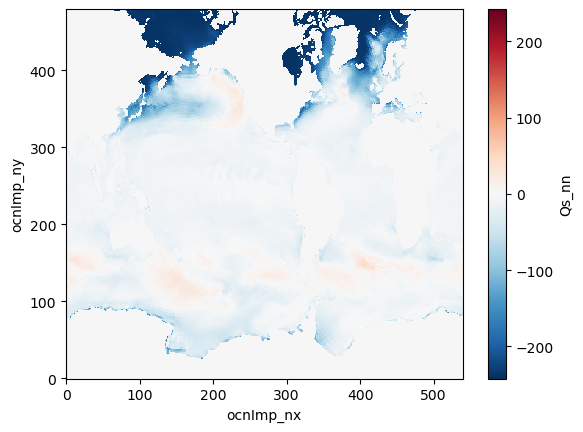

In [ ]:
ds.Qs_nn.mean(dim='time').plot(vmax=500, vmin=-500, cmap='RdBu_r')

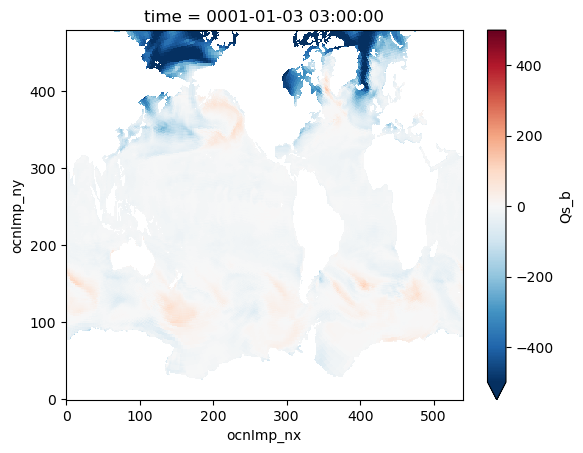

In [12]:
ds.Qs_b.isel(time=50).plot(vmax=500, vmin=-500, cmap='RdBu_r')

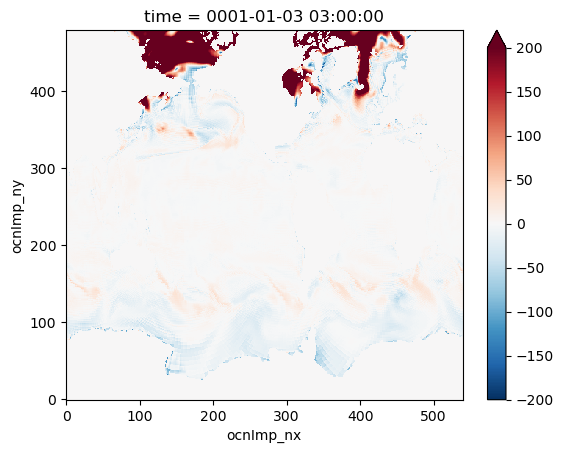

In [5]:
diff = (ds.Qs_nn - ds.Med_aoflux_ocn_Faox_sen)
diff.isel(time=50).plot(vmax=200, vmin=-200, cmap='RdBu_r')

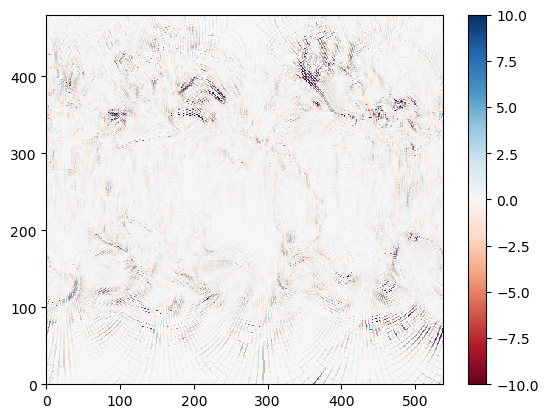

In [30]:
import matplotlib.pyplot as plt
plt.pcolormesh(np.diff(np.diff(ds.ux.isel(time=50), axis=-1), axis=-1), cmap='RdBu', vmin=-10,vmax=10)
plt.colorbar()

In [13]:
ds.sizes['time']

119

In [ ]:
ds.taux_nn.isel(time=0).plot(cmap='RdBu_r')

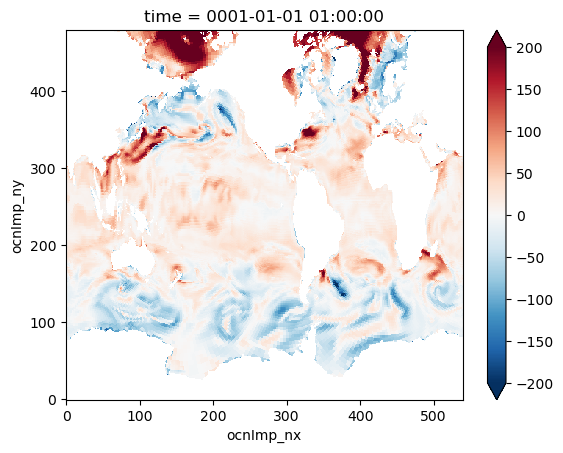

In [7]:
diff = (ds.Ql_nn + ds.Qs_nn - ds.Ql_b - ds.Qs_b) 
diff.isel(time=0).plot(vmax=200, vmin=-200, cmap='RdBu_r')

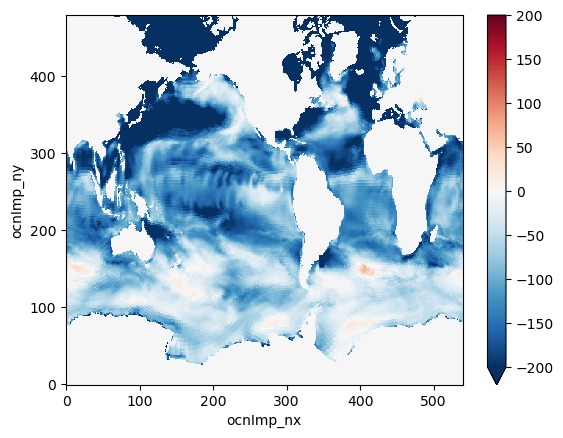

In [10]:
Q = ds.Ql_nn + ds.Qs_nn 
Q.mean('time').plot(vmax=200, vmin=-200, cmap='RdBu_r')

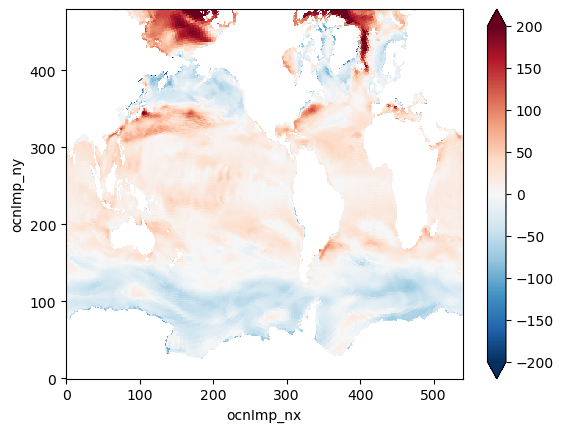

In [9]:
diff = (ds.Ql_nn + ds.Qs_nn - ds.Ql_b - ds.Qs_b)
diff.mean('time').plot(vmax=200, vmin=-200, cmap='RdBu_r')

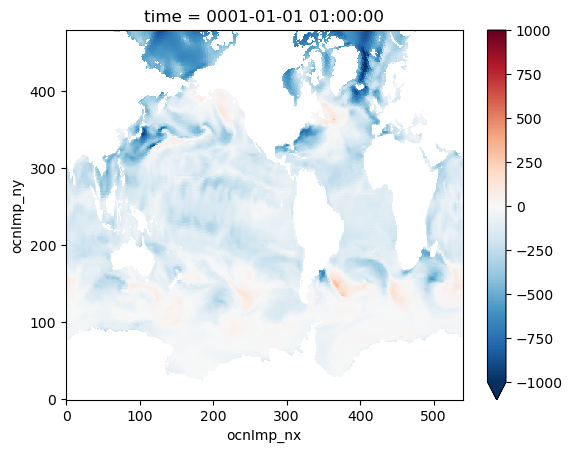

In [15]:
total = (ds.Ql_b + ds.Qs_b) * ds.ocnImp_So_omask
total.isel(time=0).plot(cmap='RdBu_r', vmax=1000, vmin=-1000)

In [17]:
pattern = r".*q.*"  # starts with 'q'
pattern = r"Med_aoflux.*_Faox.*"
matching_vars = [var for var in ds.data_vars if re.match(pattern, var)]
print(matching_vars)

['Med_aoflux_ocn_Faox_evap', 'Med_aoflux_ocn_Faox_lat', 'Med_aoflux_ocn_Faox_lwup', 'Med_aoflux_ocn_Faox_sen', 'Med_aoflux_ocn_Faox_taux', 'Med_aoflux_ocn_Faox_tauy', 'Med_aoflux_atm_Faox_evap', 'Med_aoflux_atm_Faox_lat', 'Med_aoflux_atm_Faox_lwup', 'Med_aoflux_atm_Faox_sen', 'Med_aoflux_atm_Faox_taux', 'Med_aoflux_atm_Faox_tauy']


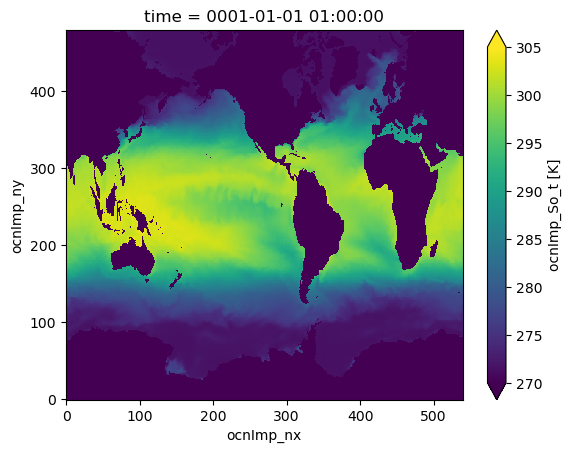

In [8]:
ds.isel(time=0).ocnImp_So_t.plot(vmin=270, vmax=305)

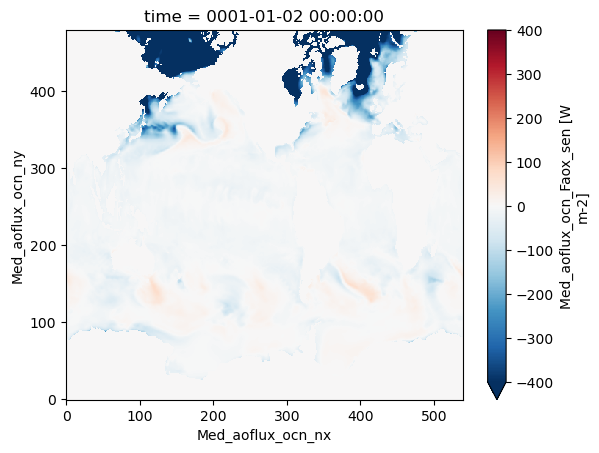

In [21]:
ds.Med_aoflux_ocn_Faox_sen.plot(vmax=400, vmin=-400, cmap='RdBu_r')

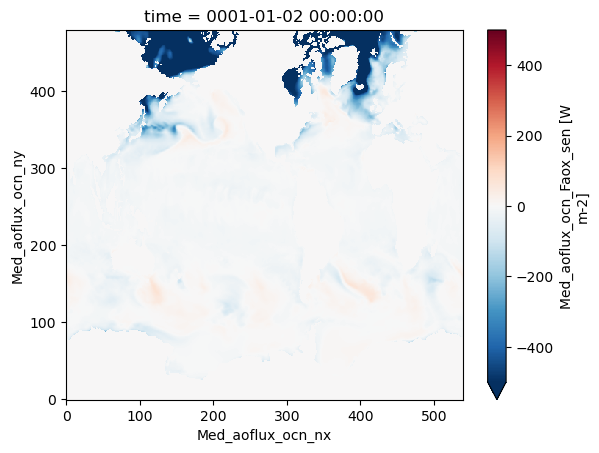

In [35]:
ds.Med_aoflux_ocn_Faox_sen.plot(x='Med_aoflux_ocn_nx', y='Med_aoflux_ocn_ny', 
                                vmax=500, vmin=-500, cmap='RdBu_r')